In [37]:
import pandas as pd
from prophet import Prophet
import matplotlib.pyplot as plt
from prophet.plot import plot_plotly, plot_components_plotly
from sklearn.metrics import mean_absolute_error, mean_squared_error
from ipywidgets import interact, IntSlider
from statsmodels.tsa.seasonal import seasonal_decompose

In [38]:
# Replace with your own path or drive mount
df = pd.read_csv('/content/sample_data/milk_production_data (1).csv')
# Prophet expects columns "ds" (date) and "y" (value)
df.rename(columns={'Milk.Prod': 'y'}, inplace=True)

# Create a 'ds' column by combining 'Year' and 'Month' and convert to datetime
df['ds'] = pd.to_datetime(df['Year'].astype(str) + '-' + df['Month'].astype(str) + '-01')


df = df.drop(["Cotagecheese.Prod","Icecream.Prod","N.CA.Fat.Price","Month.Count","monthNumSqred","monthNumCubed"], axis=1)
df


,Year,Month,y,ds
0,1995,Jan,2.112,1995-01-01
1,1995,Feb,1.932,1995-02-01
2,1995,Mar,2.162,1995-03-01
3,1995,Apr,2.130,1995-04-01
4,1995,May,2.227,1995-05-01
...,...,...,...,...
223,2013,Aug,3.400,2013-08-01
224,2013,Sep,3.197,2013-09-01
225,2013,Oct,3.338,2013-10-01
226,2013,Nov,3.275,2013-11-01


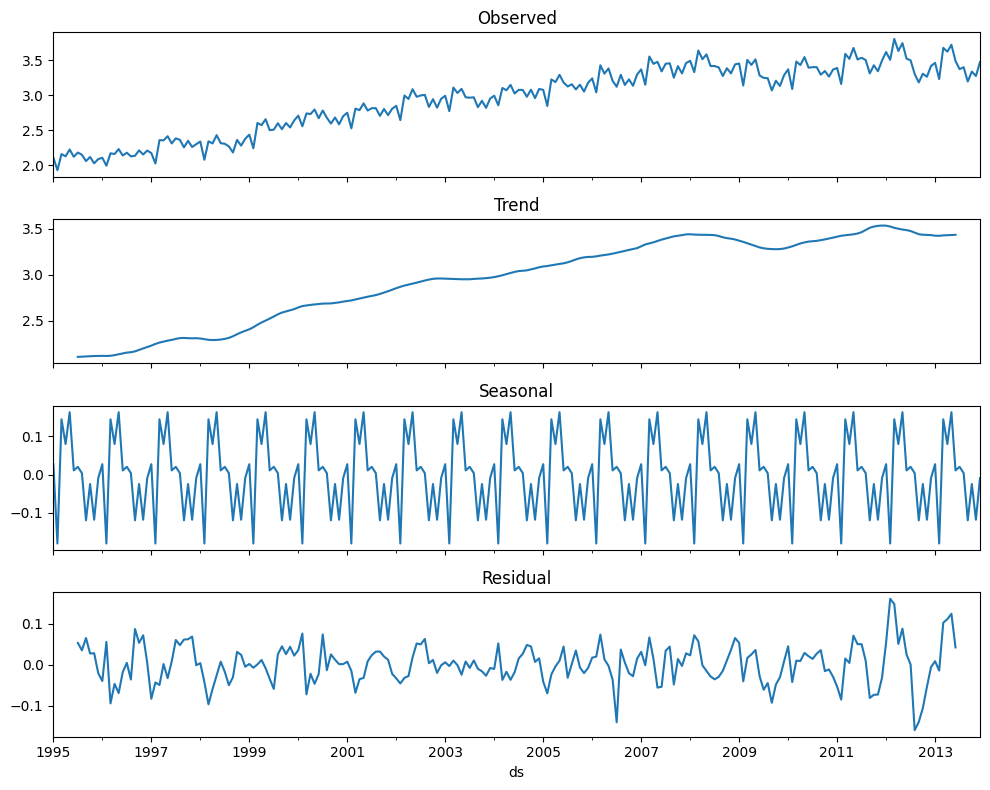

In [39]:
# Decompose to visualize seasonality
result = seasonal_decompose(df.set_index('ds')['y'], model='additive', period=12)

# Plot decomposition
fig, axes = plt.subplots(4, 1, figsize=(10, 8), sharex=True)
result.observed.plot(ax=axes[0], title='Observed')
result.trend.plot(ax=axes[1], title='Trend')
result.seasonal.plot(ax=axes[2], title='Seasonal')
result.resid.plot(ax=axes[3], title='Residual')
plt.tight_layout()
plt.show()

In [42]:
m = Prophet(
    yearly_seasonality=True,
    weekly_seasonality=True,
    daily_seasonality=False,
    changepoint_prior_scale=0.4
)
m.add_seasonality(name='weekly', period=7, fourier_order=3)
m.add_country_holidays(country_name='IN')  # For India
# m.add_regressor('humidity')
# Add monthly seasonality component
# m.add_seasonality(name='monthly', period=30.5, fourier_order=5)


# m = Prophet(
#     yearly_seasonality=True,
#     weekly_seasonality=False,
#     daily_seasonality=False,
#     changepoint_prior_scale=0.1
# )
# m.add_seasonality(name='weekly', period=7, fourier_order=3) # Removed weekly seasonality
# m.add_country_holidays(country_name='IN')
# # m.add_country_holidays(country_name='IN')  # For India
# # Add monthly seasonality component
# # m.add_seasonality(name='monthly', period=30.5, fourier_order=5)

m.fit(df)

DEBUG:cmdstanpy:input tempfile: /tmp/tmph269erh2/a5n05h90.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmph269erh2/h431_yvl.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=93220', 'data', 'file=/tmp/tmph269erh2/a5n05h90.json', 'init=/tmp/tmph269erh2/h431_yvl.json', 'output', 'file=/tmp/tmph269erh2/prophet_model9o3jsmif/prophet_model-20250708101014.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:10:14 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:10:14 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [47]:
# prompt: make the forecast for future based on user input in the graph. seperate the color for original data blue and future data red

import matplotlib.pyplot as plt
@interact(future_periods=IntSlider(min=1, max=360, step=1, value=12, description='Future Periods:'))
def plot_forecast_with_interaction(future_periods):
    future = m.make_future_dataframe(periods=future_periods, freq='MS')
    forecast = m.predict(future)

    fig = m.plot(forecast)
    ax = fig.gca()

    # Find the index where the original data ends and future data begins
    split_index = len(df)

    # Plot original data in blue
    ax.plot(df['ds'], df['y'], 'b.', label='Observed Data')

    # Plot future data in red
    ax.plot(forecast['ds'][split_index:], forecast['yhat'][split_index:], 'r-', label='Forecasted Data')

    # Add labels and title
    ax.set_xlabel('Date')
    ax.set_ylabel('Milk Production')
    ax.set_title('Milk Production Forecast')
    ax.legend()
    plt.show()


interactive(children=(IntSlider(value=12, description='Future Periods:', max=360, min=1), Output()), _dom_clas…

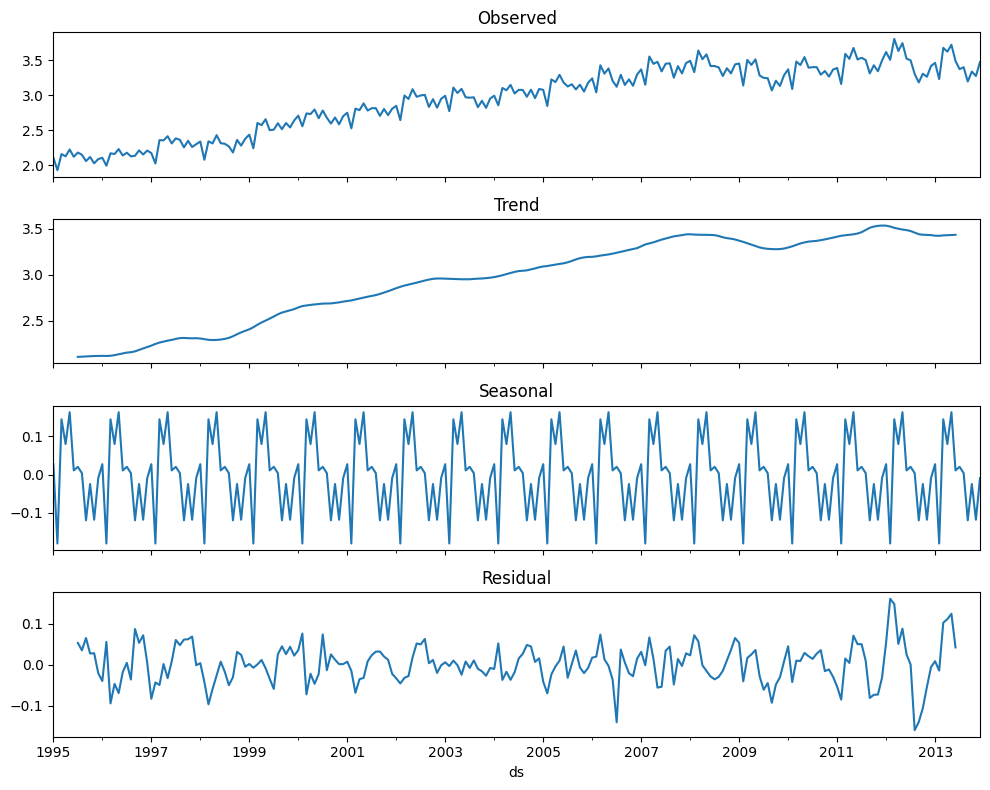

DEBUG:cmdstanpy:input tempfile: /tmp/tmph269erh2/v1yx2tlo.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmph269erh2/_lwf07ox.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=65732', 'data', 'file=/tmp/tmph269erh2/v1yx2tlo.json', 'init=/tmp/tmph269erh2/_lwf07ox.json', 'output', 'file=/tmp/tmph269erh2/prophet_model2zfhh9h_/prophet_model-20250708102726.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:27:26 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:27:26 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


interactive(children=(IntSlider(value=12, description='Months to Forecast:', max=600, min=1), Output()), _dom_…

In [48]:
# prompt: find all error of the model

import pandas as pd
from prophet import Prophet
import matplotlib.pyplot as plt
from prophet.plot import plot_plotly, plot_components_plotly
from sklearn.metrics import mean_absolute_error, mean_squared_error
from ipywidgets import interact, IntSlider
from statsmodels.tsa.seasonal import seasonal_decompose

# Replace with your own path or drive mount
df = pd.read_csv('/content/sample_data/milk_production_data (1).csv')

# Prophet expects columns "ds" (date) and "y" (value)
df.rename(columns={'Milk.Prod': 'y'}, inplace=True)

# Create a 'ds' column by combining 'Year' and 'Month' and convert to datetime
df['ds'] = pd.to_datetime(df['Year'].astype(str) + '-' + df['Month'].astype(str) + '-01')

df = df.drop(["Cotagecheese.Prod","Icecream.Prod","N.CA.Fat.Price","Month.Count","monthNumSqred","monthNumCubed"], axis=1)
df

# Decompose to visualize seasonality
# Ensure 'ds' is the index for decomposition
result = seasonal_decompose(df.set_index('ds')['y'], model='additive', period=12)

# Plot decomposition
fig, axes = plt.subplots(4, 1, figsize=(10, 8), sharex=True)
result.observed.plot(ax=axes[0], title='Observed')
result.trend.plot(ax=axes[1], title='Trend')
result.seasonal.plot(ax=axes[2], title='Seasonal')
result.resid.plot(ax=axes[3], title='Residual')
plt.tight_layout()
plt.show()

m = Prophet(
    yearly_seasonality=True,
    weekly_seasonality=False, # Keep weekly_seasonality=False as desired
    daily_seasonality=False,
    changepoint_prior_scale=0.1
)

# Do not add weekly seasonality here if weekly_seasonality is set to False in Prophet
# If you want weekly seasonality, set weekly_seasonality=True in Prophet constructor
# m.add_seasonality(name='weekly', period=7, fourier_order=3)

# m.add_country_holidays(country_name='IN')  # For India
# Add monthly seasonality component if needed
# m.add_seasonality(name='monthly', period=30.5, fourier_order=5)

m.fit(df)

def create_future_forecast_plot(months_to_forecast):
    future = m.make_future_dataframe(periods=months_to_forecast, freq='MS') # 'MS' for Month Start
    forecast = m.predict(future)

    fig, ax = plt.subplots(figsize=(10, 6))

    # Plot the original data
    ax.plot(df['ds'], df['y'], label='Original Data', color='blue')

    # Plot the forecast data (including historical and future)
    # Ensure the x-axis is the same date format
    ax.plot(forecast['ds'], forecast['yhat'], label='Forecast', color='orange')

    # Highlight the future forecast period - This part might be tricky with direct filling.
    # A simpler approach is to plot the forecast and highlight the legend.
    # If you specifically want to highlight the future region on the plot,
    # you can plot the forecast['ds'] from the point after the original data ends.
    # future_forecast_start_idx = forecast[forecast['ds'] > df['ds'].max()].index[0]
    # ax.fill_between(forecast['ds'][future_forecast_start_idx:],
    #                 forecast['yhat_lower'][future_forecast_start_idx:],
    #                 forecast['yhat_upper'][future_forecast_start_idx:],
    #                 color='orange', alpha=0.2, label='Forecast Interval')

    # Plot the forecast interval for the entire forecast period
    ax.fill_between(forecast['ds'], forecast['yhat_lower'], forecast['yhat_upper'], color='orange', alpha=0.2, label='Forecast Interval')


    ax.set_xlabel('Date')
    ax.set_ylabel('Milk Production')
    ax.set_title('Milk Production Forecast')
    ax.legend()
    plt.show()

# Ensure ipywidgets is installed if running outside a default Colab environment
# !pip install ipywidgets

interact(create_future_forecast_plot, months_to_forecast=IntSlider(min=1, max=600, step=1, value=12, description='Months to Forecast:'));
